## Tiny NeRF (A PyTorch implementation)

NeRF:NeRF: Representing scenes as neural radiance fields for view synthesis 논문을 간단히 구현하는 과제를 수행합니다.

논문의 저자들은 논문을 TensorFlow로 구현 하였고, 이 코드는 기존의 코드를 PyTorch로 바꿔서 구현된 코드입니다.

In [ ]:
# 필요한 라이브러리 import
from typing import Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
import math  # pi를 사용하기 위해
import torch.nn as nn  # nn 모듈 임포트
import torch.nn.functional as F

## A few utility functions

#### Bridging PyTorch and TensorFlow functionality

PyTorch와 TensorFlow 사이의 차이를 제거하기 위해 만든 일부 모듈들입니다.

- meshgrid_xy

  tensor1과 tensor2라는 두 개의 텐서를 사용하고 해당하는 meshgrid를 반환합니다.

- cumprod_exclusive

  torch.cumprod 함수는 tensor의 지정된 축을 따라 누적 곱을 계산합니다. exclusive 옵션을 True로 하면 exclusive하게 누적 곱을 계산합니다.

In [ ]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """
    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  """
  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

#### Compute the "bundle" of rays through all pixels of an image.

이미지의 모든 픽셀을 통과하는 ray들을 계산합니다.

In [ ]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  """Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
  """
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

#### Compute "query" 3D points given the "bundle" of rays.

주어진 ray들을 통해 각 ray의 query 3D point들(x, y, z)을 계산합니다.

volume of interest를 나타내는 _near_와 _far_ clipping 거리가 제공된다고 가정합니다. 각 ray는 이 범위 내에서만 평가됩니다. ray의 대부분이 샘플에 걸쳐지도록 하면서 각 ray를 따라 점을 무작위로 샘플링합니다.

In [ ]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True
) -> (torch.Tensor, torch.Tensor):
  r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
  variables indicate the bounds within which 3D points are to be sampled.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray in the "bundle".

  Returns:
    query_points (torch.Tensor): Query points along each ray
      (shape: :math:`(width, height, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).
  """
  # shape: (num_samples)
  depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
  if randomize is True:
    # ray_origins: (width, height, 3)
    # noise_shape = (width, height, num_samples)
    noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
    # depth_values: (num_samples)
    depth_values = depth_values \
        + torch.rand(noise_shape).to(ray_origins) * (far_thresh
            - near_thresh) / num_samples
  # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
  # query_points:  (width, height, num_samples, 3)
  query_points = ray_origins[..., None, :] + ray_directions[..., None, :] * depth_values[..., :, None]

  return query_points, depth_values

#### Volumetric rendering

각 ray의 원점과 이를 따라 샘플링된 깊이 값이 주어지면 radiance field를 다르게 렌더링합니다.

In [ ]:
def render_volume_density(
    radiance_field: torch.Tensor,
    ray_origins: torch.Tensor,
    depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

  Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
  """
  # TESTED
  sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
  rgb = torch.sigmoid(radiance_field[..., :3])
  one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
  dists = torch.cat((depth_values[..., 1:] - depth_values[..., :-1],
                  one_e_10.expand(depth_values[..., :1].shape)), dim=-1)
  alpha = 1. - torch.exp(-sigma_a * dists)
  weights = alpha * cumprod_exclusive(1. - alpha + 1e-10)

  rgb_map = (weights[..., None] * rgb).sum(dim=-2)
  depth_map = (weights * depth_values).sum(dim=-1)
  acc_map = weights.sum(-1)

  return rgb_map, depth_map, acc_map

#### Positional encoding

NeRF에서 사용되는 "positional encoding"으로, 이는 고차원 공간에 대한 매핑 사용을 가정합니다. 이것은 모델의 기능을 크게 향상시킵니다.

##### 문제 1

다음 그림과 코드를 분석하여 빈칸 채우기

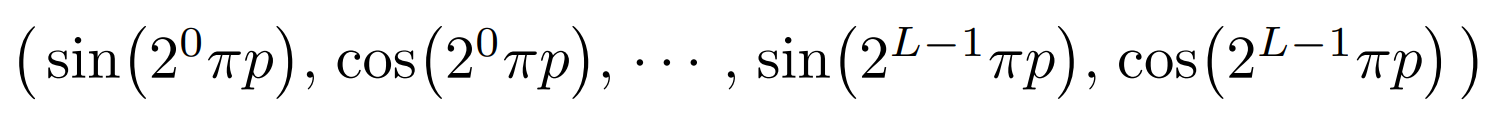

In [ ]:
def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True
) -> torch.Tensor:
  r"""Apply positional encoding to the input.

  Args:
    tensor (torch.Tensor): Input tensor to be positionally encoded.
    num_encoding_functions (optional, int): Number of encoding functions used to
        compute a positional encoding (default: 6).
    include_input (optional, bool): Whether or not to include the input in the
        computed positional encoding (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  # Trivially, the input tensor is added to the positional encoding.
  encoding = [tensor] if include_input else []
  # Now, encode the input using a set of high-frequency functions and append the
  # resulting values to the encoding.
  frequency_bands = []

  ###     Steps:
  ###       1) sin, cos 에 적용될 frequency_bands를 작성

  ############## START CODE HERE ##############

  for i in range(num_encoding_functions):
    frequency_bands.append((2**i)*math.pi)


  ############## END CODE HERE ##############

  for freq in frequency_bands:
      for func in [torch.sin, torch.cos]:
          encoding.append(func(tensor * freq))

  # Special case, for no positional encoding
  if len(encoding) == 1:
      return encoding[0]
  else:
      return torch.cat(encoding, dim=-1)

## TinyNeRF: Network architecture

##### 문제 2

다음 네트워크 그림을 보고 네트워크 구현

( skip을 제외한 argument 값 수정 금지 )


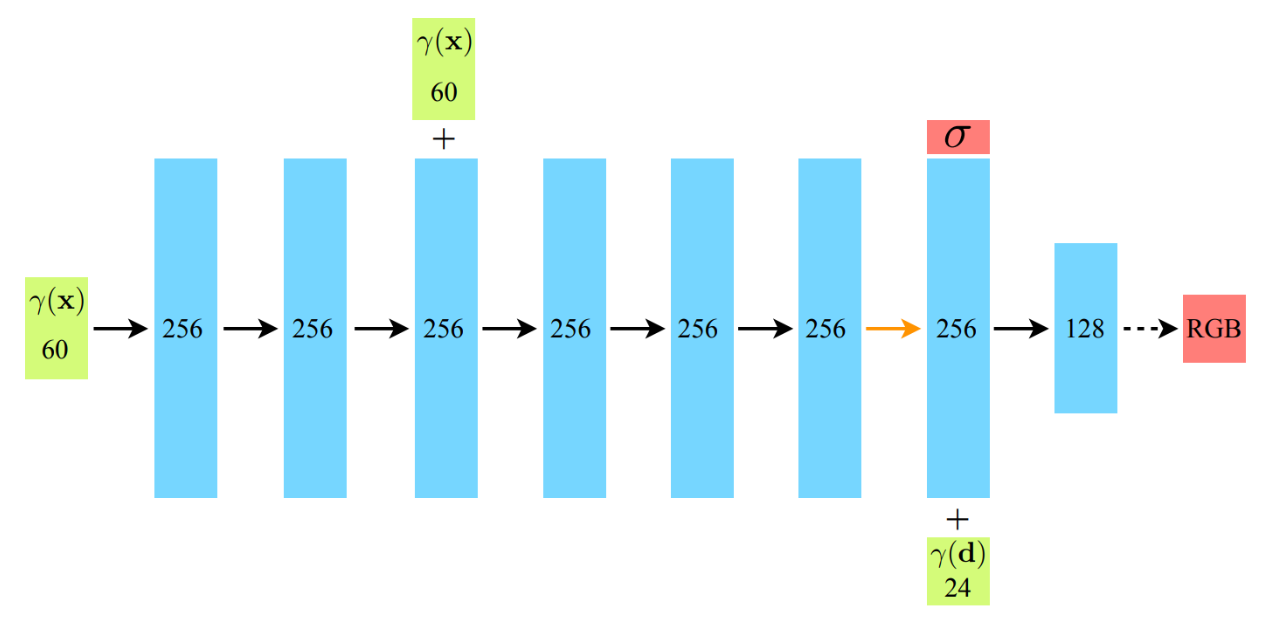

In [ ]:
class NerfModel(nn.Module):
  r"""Define a NeRF model comprising three fully connected layers.
  """
  def __init__(self, D=6, filter_size=256, skip=[2], num_encoding_functions=10, num_encoding_dir_functions=4):
    """
    Args:
      D : 중간 layer의 개수 (주황색 화살표 이전의 layer)
      filer_size : layer의 channel 개수
      skip : skip connection을 추가할 layer의 number
      num_encoding_functions : 3d point의 positional embedding freq number
      num_encoding_dir_functions : direction의 positional embedding freq number
    """
    super(NerfModel, self).__init__()
    self.input_ch = 3 + 3 * 2 * num_encoding_functions
    self.input_ch_views = 3 + 3 * 2 *num_encoding_dir_functions
    self.skips = skip
    ############## START CODE HERE ##############
    self.pts_linears = nn.ModuleList(
            [nn.Linear(self.input_ch, filter_size)] + [nn.Linear(filter_size, filter_size) if i not in self.skips else nn.Linear(filter_size + self.input_ch, filter_size) for i in range(D-1)])
    self.views_linears = nn.ModuleList([nn.Linear(self.input_ch_views + filter_size, filter_size//2)])

    self.feature_linear = nn.Linear(filter_size, filter_size)
    self.alpha_linear = nn.Linear(filter_size, 1)
    self.rgb_linear = nn.Linear(filter_size//2, 3)

    ############## END CODE HERE ##############
  def forward(self, x):
    input_pts, input_views = torch.split(x, [self.input_ch, self.input_ch_views], dim=-1)

    ############## START CODE HERE ##############

    h = input_pts
    for i, l in enumerate(self.pts_linears):
      h = self.pts_linears[i](h)
      h = F.relu(h)
      if i in self.skips:
        h = torch.cat([input_pts, h], -1)

    alpha = self.alpha_linear(h)
    feature = self.feature_linear(h)
    h = torch.cat([feature, input_views], -1)

    for i, l in enumerate(self.views_linears):
      h = self.views_linears[i](h)
      h = F.relu(h)

    rgb = self.rgb_linear(h)
    outputs = torch.cat([rgb, alpha], -1)

    ############## END CODE HERE ##############
    outputs = torch.cat([rgb, alpha], -1)
    return outputs

## Minibatch utils

큰 tensor(ray들의 집합)를 가져와 미니배치 리스트로 나눕니다

In [ ]:
def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
  r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
  Each element of the list (except possibly the last) has dimension `0` of length
  `chunksize`.
  """
  return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]

## Get data

In [ ]:
# Download sample data used in the official tiny_nerf example
import os
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

--2023-06-13 07:26:55--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-06-13 07:26:56--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  5.96MB/s    in 2.0s    

2023-06-13 07:26:58 (5.96 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



## Determine device to run on (GPU vs CPU)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load up input images, poses, intrinsics, etc.

In [ ]:
# Load input images, poses, and intrinsics
data = np.load("tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.
far_thresh = 6.

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

#### Display the image used for testing

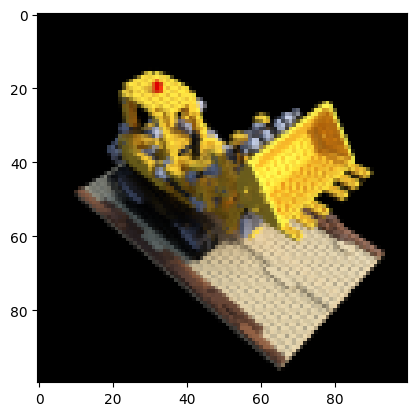

In [ ]:
plt.imshow(testimg.detach().cpu().numpy())
plt.show()

## Train TinyNeRF!

In [ ]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(height, width, focal_length, tform_cam2world,
                             near_thresh, far_thresh, depth_samples_per_ray,
                             encoding_function, encoding_dir_function, get_minibatches_function):

  # Get the "bundle" of rays through all image pixels.
  ray_origins, ray_directions = get_ray_bundle(height, width, focal_length,
                                               tform_cam2world)

  # Sample query points along each ray
  query_points, depth_values = compute_query_points_from_rays(
      ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
  )

  # Get the direction that will be input direction
  direction = ray_directions
  direction = direction / torch.norm(direction, dim=-1, keepdim=True)
  direction = direction[...,None, :].expand(query_points.shape)

  # "Flatten" the query points and the direction
  flattened_query_points = query_points.reshape((-1, 3))
  flattened_direction = direction.reshape((-1, 3))

  # Encode the query points and the direction (default: positional encoding).
  encoded_points = encoding_function(flattened_query_points)
  encoded_direction = encoding_dir_function(flattened_direction)

  embedded = torch.cat([encoded_points, encoded_direction], -1)

  # Split the encoded points into "chunks", run the model on all chunks, and
  # concatenate the results (to avoid out-of-memory issues).
  batches = get_minibatches_function(embedded, chunksize=chunksize)
  predictions = []
  for batch in batches:
    predictions.append(model(batch))
  radiance_field_flattened = torch.cat(predictions, dim=0)

  # "Unflatten" to obtain the radiance field.
  unflattened_shape = list(query_points.shape[:-1]) + [4]
  radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

  # Perform differentiable volume rendering to re-synthesize the RGB image.
  rgb_predicted, _, _ = render_volume_density(radiance_field, ray_origins, depth_values)

  return rgb_predicted

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loss: 0.18050774931907654


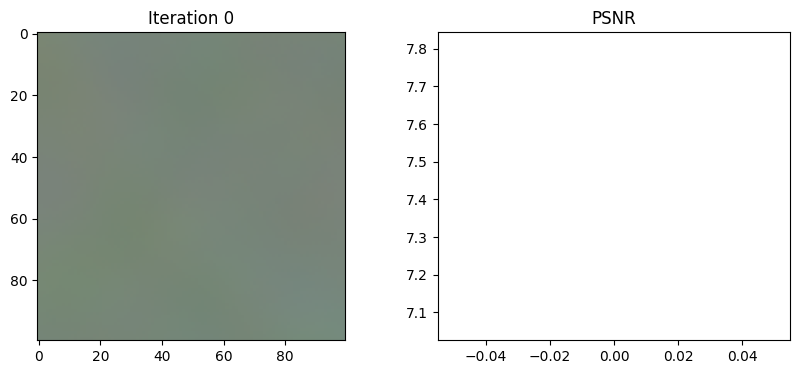

Loss: 0.07872828096151352


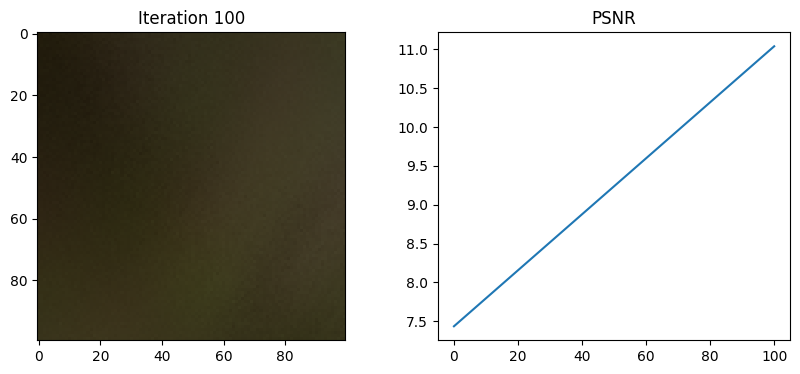

Loss: 0.06713264435529709


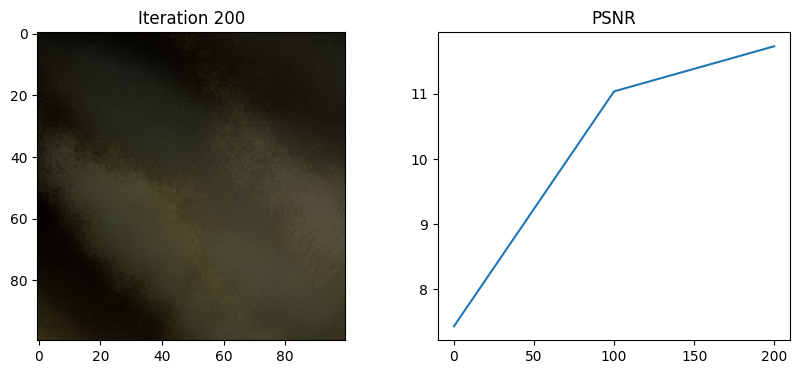

Loss: 0.02382848970592022


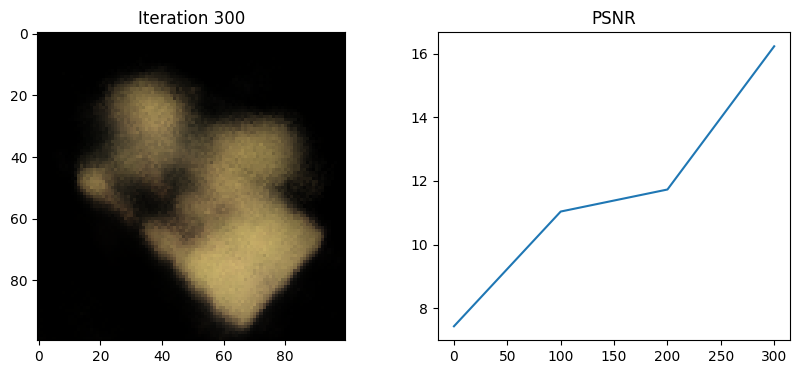

Loss: 0.012763142585754395


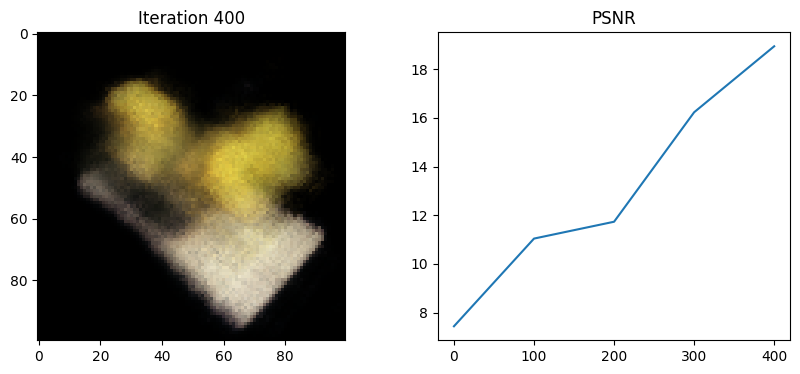

Loss: 0.013197656720876694


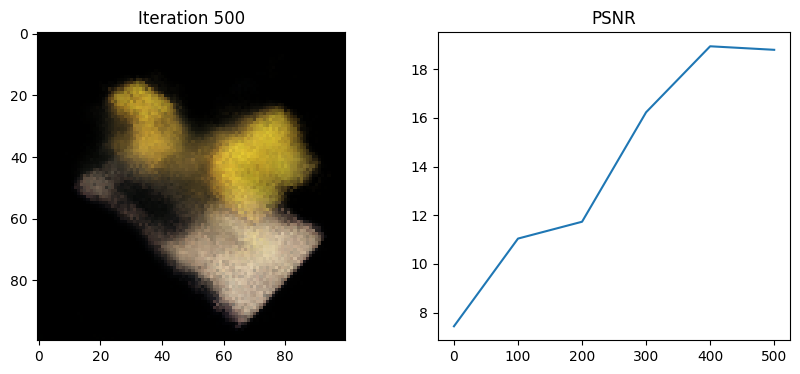

Loss: 0.01079551037400961


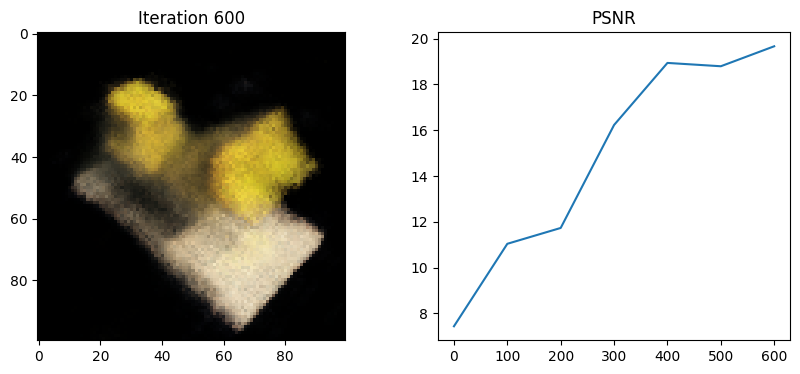

Loss: 0.009254992939531803


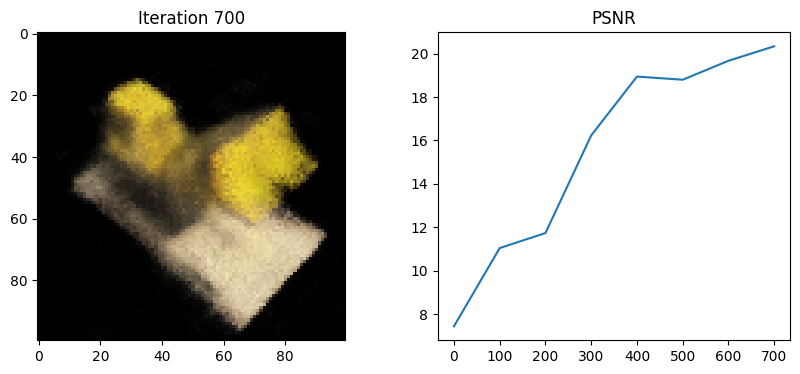

Loss: 0.007886312901973724


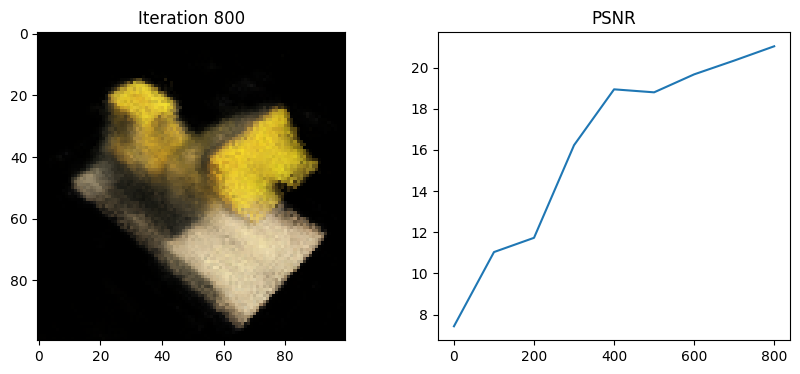

Loss: 0.00843103602528572


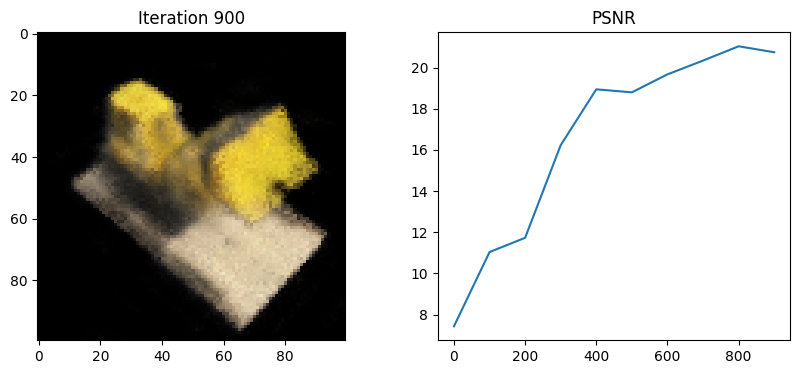

Loss: 0.006911893840879202


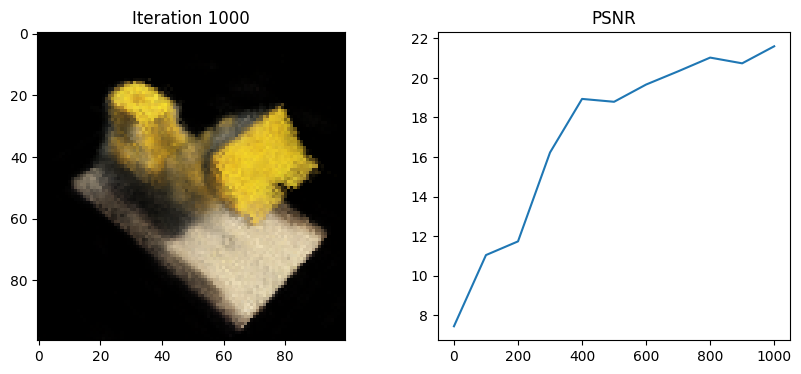

Loss: 0.006473880261182785


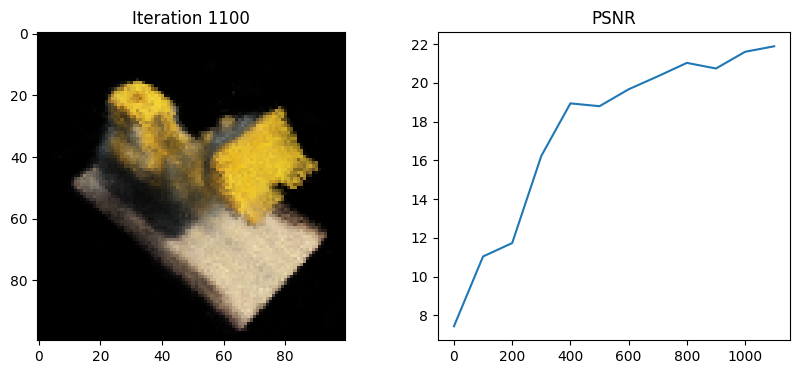

Loss: 0.006596850696951151


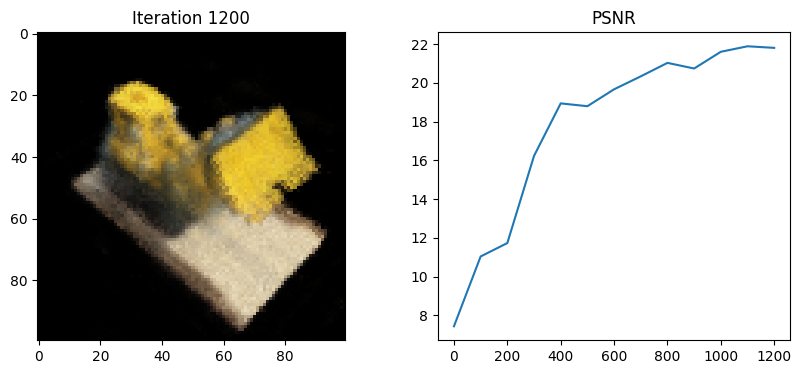

Loss: 0.0065259141847491264


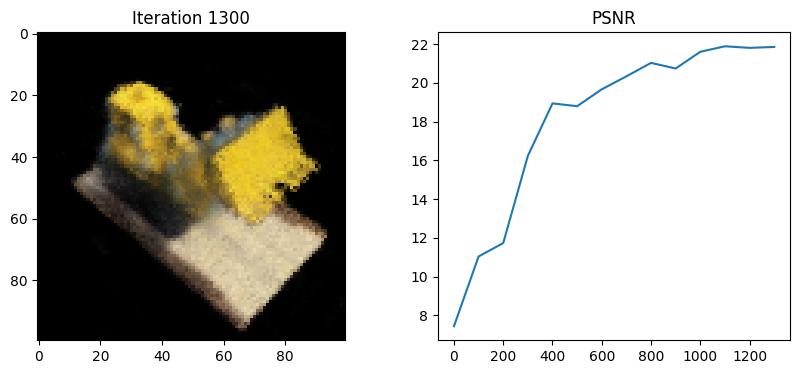

Loss: 0.006718188524246216


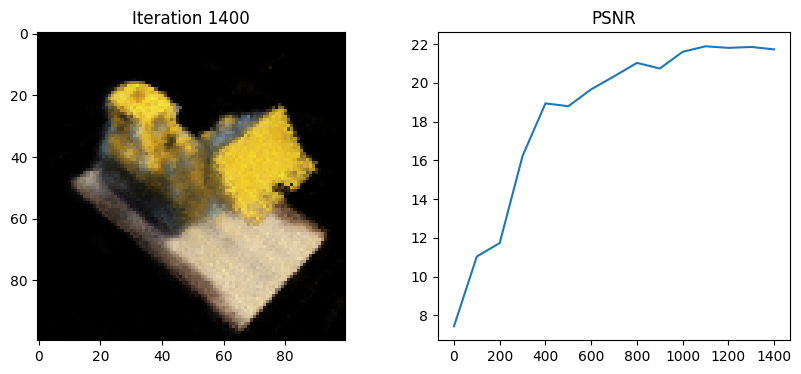

Loss: 0.006743926554918289


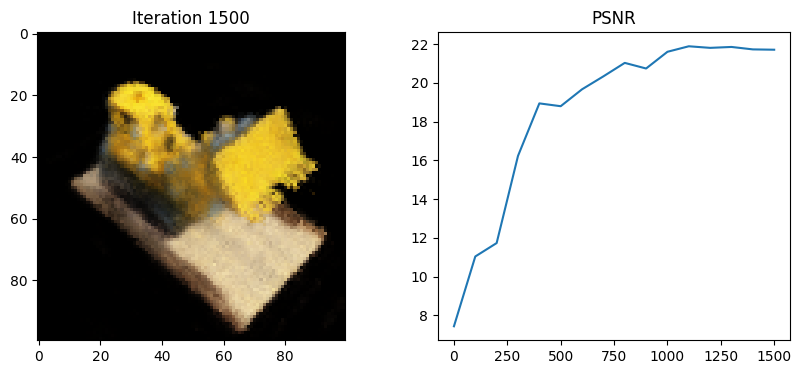

Loss: 0.0055431765504181385


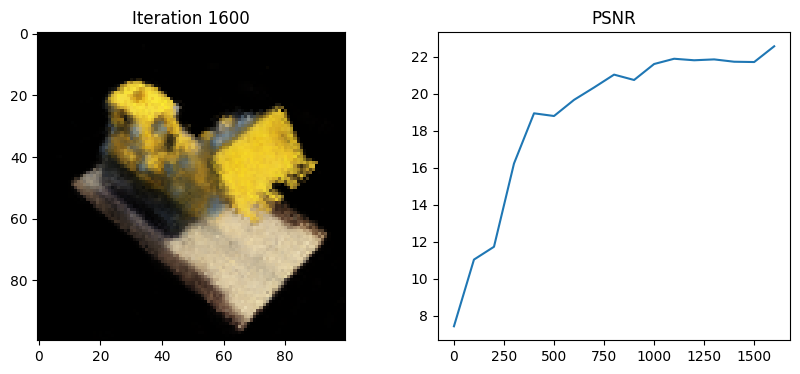

Loss: 0.006218739785254002


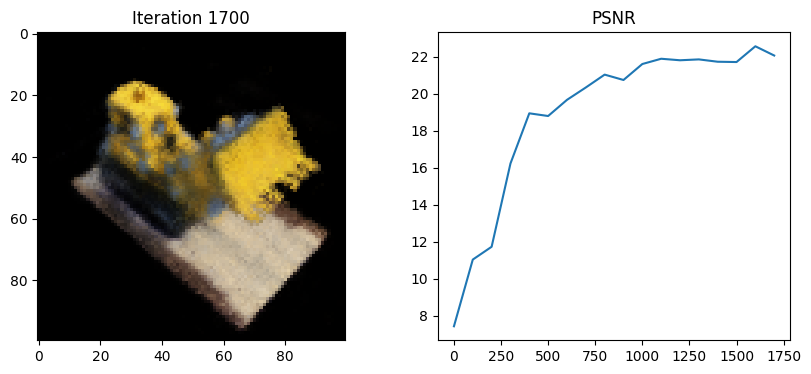

Loss: 0.005229505244642496


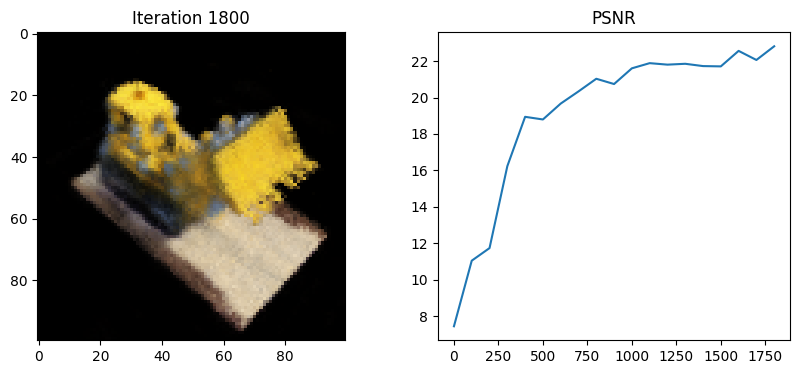

Loss: 0.00481100520119071


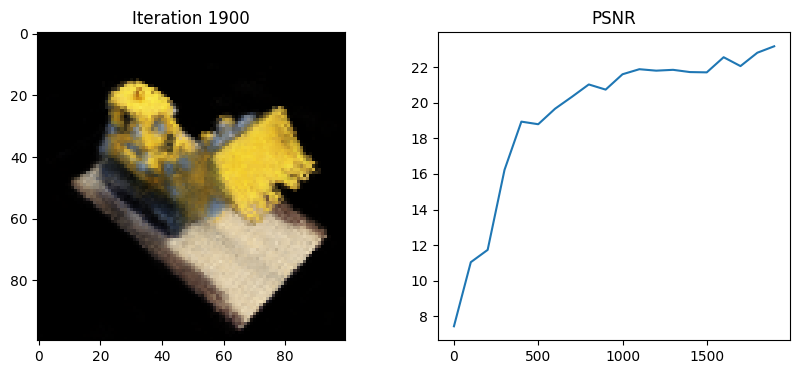

In [ ]:
"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 10
num_encoding_dir_functions = 4
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_functions)
dir_encode = lambda x: positional_encoding(x, num_encoding_functions=num_encoding_dir_functions)
# Number of depth samples along each ray.
depth_samples_per_ray = 64

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
chunksize = 16384  # Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory.

# Optimizer parameters
lr = 5e-4
num_iters = 2000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

"""
Model
"""
model = NerfModel(D=6, filter_size=256, skip=[2], num_encoding_functions=num_encoding_functions, num_encoding_dir_functions=num_encoding_dir_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

for i in range(num_iters):

  # Randomly pick an image as the target.
  target_img_idx = np.random.randint(images.shape[0])
  target_img = images[target_img_idx].to(device)
  target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

  # Run one iteration of TinyNeRF and get the rendered RGB image.
  rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                           target_tform_cam2world, near_thresh,
                                           far_thresh, depth_samples_per_ray,
                                           encode, dir_encode, get_minibatches)

  # Compute mean-squared error between the predicted and target images. Backprop!
  loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

  # Display images/plots/stats
  if i % display_every == 0:
    # Render the held-out view
    rgb_predicted = run_one_iter_of_tinynerf(height, width, focal_length,
                                             testpose, near_thresh,
                                             far_thresh, depth_samples_per_ray,
                                             encode, dir_encode, get_minibatches)
    loss = torch.nn.functional.mse_loss(rgb_predicted, testimg)
    print("Loss:", loss.item())
    psnr = -10. * torch.log10(loss)

    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(122)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.show()

print('Done!')

## 문제 3

위에서 학습한 결과 이미지 비교

( 500 iter, 1500 iter, 1900 iter )

## 문제 4

skip connection의 위치를 변경 그리고 skip connection을 제거해보기

 마지막 iteration 결과 이미지를 비교

 (총 3개의 이미지 - 3번째 layer에 skip connection 적용, 5번째 layer에 skip connection 적용, skip connection 완전 제거)

#### Example

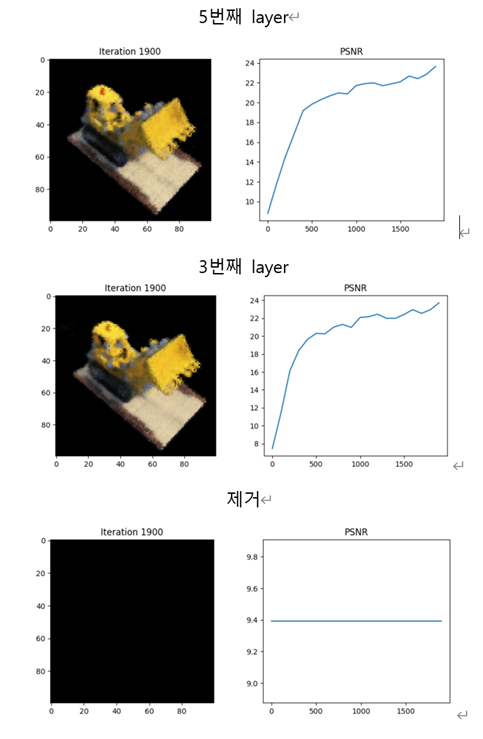